In [1]:
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import sys
sys.path.append('rl_tests/additive_rework/')
from mlp import *
from old_mlp import OldMLP
from tqdm import tqdm
import itertools
from utils import *
import pandas as pd
from scipy.ndimage import gaussian_filter1d
from simple_agent import *
from buffer import *

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(1234)

%load_ext autoreload
%autoreload 2
#plt.style.use('dark_background')
plt.style.use('seaborn-deep')

## Warning!
#### This code provides functionality for opitmization on the Mazzler device.
#### Loading settings without the supervision of a responsible physicist is not advised.

# Set parameters

In [3]:
# Model selection 

#old base triangle model
#pt_agent_name = "512_1_20000000_gsq02exp_sparkling-water-122"

#pt_agent_name = '512_1_20000000_24xpyzss_stoic-lake-149' # 1 512 layer zf follow up with loss focus on power

# fallen-morning-220 power norm pwl run with last
#pt_agent_name = 'data_fix_512_1_20000000_1o87kafl_fallen-morning-220'
#pt_agent_name = 'pwl_noloopfix_data_fix_512_1_20000000_17z8os5g_thoughtful-lovebird-260' #continue with lab

## pwl power norm with hole
#pt_agent_name = 'data_fix_512_1_20000000_2l0wz3qp_stilted-thunder-244'

# comfy-bird-200 with last pwl
pt_agent_name = 'data_fix_512_1_20000000_3faoyjga_comfy-bird-200'
#pt_agent_name = 'pwl_noloopfix_data_fix_512_1_20000000_22vnr53g_genuine-darling-258' #continue wtih lab


# hole pwl
#pt_agent_name = 'data_fix_512_1_20000000_v2llexk2_dandy-pyramid-243'
#pt_agent_name = 'pwl_noloopfix_data_fix_512_1_20000000_2ez0xqne_treasured-carnation-259' #continue wtih lab

# to add with last base+hole + power_norm
#pt_agent_name = "data_fix_512_1_20000000_1ytmamrv_splendid-water-238"

# to add with last base + power_norm
#pt_agent_name = "data_fix_512_1_20000000_39sqeyyg_dashing-resonance-235"

# to add with last base+hole 
#pt_agent_name = "data_fix_512_1_20000000_1328favo_scarlet-lion-237"

# to add with last base
#pt_agent_name = "data_fix_512_1_20000000_uu8wdvth_playful-sky-236"

# resplendent-dumpling-163 base+hole without last 
#pt_agent_name = "data_fix_512_1_20000000_3c4fdyls_resplendent-dumpling-163"

# vibrant-laughter-165 base without last
#pt_agent_name = "data_fix_512_1_20000000_3rpv3vov_vibrant-laughter-165"


#pt_surrogate_name = '512_1_20000000_3w0kc0cs_upbeat-meadow-153' # ds continue

#fresh-aardvark-232 power norm pwl 
#pt_surrogate_name = 'data_fix_512_1_2000000_31qbep0g_fresh-aardvark-232'
#pt_surrogate_name = 'loop_data_fix_512_1_10000000_3e18jlb8_charismatic-caress-264'#continue with lab

#worldly-silence-229 power norm pwl with bad
#pt_surrogate_name ='data_fix_512_1_2000000_2o3nqoa2_worldly-silence-229'

#pleasant-bush-221 pwl with bad and loop -> not that good
#pt_surrogate_name = "data_fix_512_1_2000000_3ifgu30a_pleasant-bush-221"

# rosy-pond-227 base with bad
#pt_surrogate_name = "data_fix_512_1_1000000_17bjw7gc_rosy-pond-227"

# giddy-armadillo-223 test pwl 
#pt_surrogate_name = 'data_fix_512_1_2000000_122vzfqv_giddy-armadillo-223'
#giddy continue with bad
#pt_surrogate_name = 'loop_data_fix_512_1_2000000_2i1e9kyl_mild-violet-253'
pt_surrogate_name = 'loop_data_fix_512_1_10000000_31x86z8h_beloved-sweetheart-263' #continue with lab

# base norm power
#pt_surrogate_name = "data_fix_512_1_2000000_1axbbvte_cerulean-forest-233"


surrogate_num_hidden = 1
agent_num_hidden = 1
# Optimization learning rates
agent_lr = 1e-5
surrogate_lr = 1e-5

# Count number of steps performed (incremented at wave saving)
setting_counter =0

# Plot generated wave
plot = True

# Initalize seperate Buffer, agent external (testing)
experiences = Buffer(50000)

smooth_states = True
norm_states = True
kernel_size = 25

# Fix power to a default value
fixed_power = False
fixed_power_value = 0.03

#Normalize output
norm_output = False

# Smoothing of agent output
smooth_action = False
kernel_size_action = 21
smooth_action_optim = False # Does currently not work

# Normalization as agent feature
norm_feature = False
clip_norm = False
minmax_norm=False

# Activation function in last layer
last_layer_act_agent=True
last_layer_act_surrogate=True
surrogate_act = torch.tanh

x_vals_setting = np.load('setting_x_values.npy')
x_vals_spectrum = np.load('spectrum_x_values.npy')


# mix batch parameters
mix_batch = True
exp_batch = True

pwl_train = True
norm_power = False

# Loading phase

In [4]:
states, actions = get_data(smooth_states=smooth_states, norm_states = norm_states, norm_power=norm_power)
start_states = states[:,:int(states.shape[1]/2)]
next_states = states[:,int(states.shape[1]/2):]
surrogate_states = torch.cat([start_states, actions], dim=1)
surrogate_actions = next_states
if pwl_train:
    base_actions = actions.clone()
    actions, xn, xp = get_pwl_actions(actions.float().to(device)) 
    surrogate_states, xn, xp = get_pwl_surrogate_states(surrogate_states)

In [5]:
states.shape

torch.Size([237, 4096])

In [6]:
start  = np.loadtxt('/home/bethke52/laser_data/live_2023_02_16/spectra/start_lower_intese_2023.02.16_11.48.16.txt')
state = torch.tensor(start[:,1]/3500).unsqueeze(0).float().to(device) 

#target_spectrum = gaussian_filter1d(get_target_from_data(start, normed=True)[:,1],sigma=6)
target_spectrum = gaussian_filter1d(get_target_from_data(start, normed=True)[:,1],sigma=10)
target = torch.tensor(target_spectrum/2000).unsqueeze(0).float().to(device) 

In [7]:
step = get_target_from_data(start, normed=True)
dynamic_rs = True
targets, target_labels = differ_targets(step, smooth_ramp=True, dynamic_resampling=dynamic_rs, smooth_step=True)
target_idx = 8
target = 1.1*torch.tensor(targets[target_idx]/2000).unsqueeze(0).float().to(device)
[target_labels[i] + " {}".format(i) for i in range(len(target_labels))]

['gauss_1 0',
 'gauss_2 1',
 'gauss_3 2',
 'target_shift_left 3',
 'target_shift_right 4',
 'target_smooth 5',
 'step_target 6',
 'pointy_target 7',
 'ramp_target_lr 8',
 'ramp_target_rl 9',
 'ramp_traget_lr_small 10']

In [8]:
plt.plot(x_vals_setting, spline_wave, alpha=0.8, label="With spline head")
plt.plot(x_vals_setting, base_wave, alpha=0.8, label="Without spline head")
plt.grid(alpha=0.5)
plt.ylabel("Normalized intensity", size=12)
plt.xlabel("Wavelength", size=12)
plt.xlim(750,850)
plt.legend(fontsize=12)
#plt.savefig("spline_vs_base_setting", dpi=300)
plt.title("Spline head ")

NameError: name 'spline_wave' is not defined

In [ ]:
if norm_states:
    target = norm_tensor(target, dim=1)

In [9]:
agent = SimpleAgent(input_size=states[0].shape[0], target_size=actions[0].shape[0], hidden_size=512, num_hidden=agent_num_hidden, activation = torch.sigmoid, lr=agent_lr, last_layer_activation = last_layer_act_agent, norm = norm_feature,  clip_norm = clip_norm, minmax_norm=minmax_norm, xn=xn if pwl_train else None, xp=xp if pwl_train else None)
agent.agent.load_state_dict(torch.load('/home/bethke52/laser_data/historic_data/models/'+ pt_agent_name, map_location=device))

surrogate = SimpleAgent(input_size=surrogate_states[0].shape[0], target_size=surrogate_actions[0].shape[0], hidden_size=512, num_hidden=surrogate_num_hidden, activation = surrogate_act, lr=surrogate_lr, last_layer_activation = last_layer_act_surrogate)
surrogate.agent.load_state_dict(torch.load('/home/bethke52/laser_data/historic_data/surrogates/'+ pt_surrogate_name, map_location=device))

<All keys matched successfully>

In [42]:
reset_exp_memory = False
if reset_exp_memory:
    base_path_settings = '/home/bethke52/laser_data/live_optim_data_collection_ramp_nods/settings/'
    base_path_spectra = '/home/bethke52/laser_data/live_optim_data_collection_ramp_nods/spectra/'
    start_spectrum = 'start/start_2_2023.02.14_10.57.48.txt'
    exp_rec_states, exp_rec_actions = get_live_exp_data(base_path_settings=base_path_settings, base_path_spectra= base_path_spectra, start_spectrum = start_spectrum, smooth_states=smooth_states, norm_states=norm_states, norm_power=norm_power)
    exp_rec_actions, xn, xp = get_pwl_actions(exp_rec_actions, base_waves=actions)
    experiences.state_memory = exp_rec_states[:,:2048].float().to(device) 
    experiences.action_memory = exp_rec_actions.float().to(device)
    experiences.next_state_memory = exp_rec_states[:,2048:].float().to(device)
    experiences.org_target_memory = exp_rec_states[:,2048:].float().to(device)

# Inference phase

In [43]:
start_kernel_size = kernel_size
start_kernel_size = 25
start_kernel_size 

25

In [44]:
smooth_action=False

NameError: name 'old_wave_values' is not defined

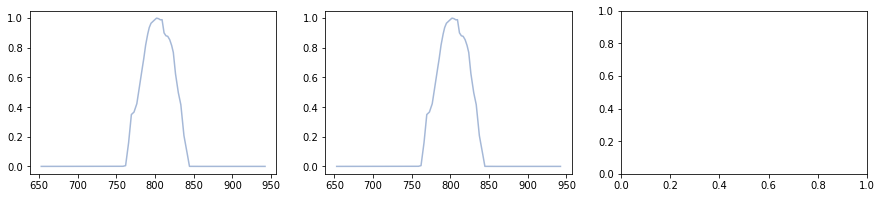

In [45]:
with torch.no_grad():
    agent_state = torch.cat([state, target],dim=1)
    # Smooth the agent state
    if smooth_states:
        agent_state[:,:2048] = torch.nn.AvgPool1d(kernel_size=start_kernel_size, stride=1, padding=start_kernel_size//2)(agent_state[:,:2048])
    # Norm the agent state
    if norm_states:
        agent_state = torch.cat([norm_tensor(agent_state[:,:2048], dim=1),norm_tensor(agent_state[:,2048:], dim=1)], dim=1)
    # Inference
    if pwl_train:
        agent.agent.pwl = False
        pwl_action = agent.agent(agent_state)
        agent.agent.pwl = True
    action = agent.agent(agent_state)

    # Extract power parameter4
    power = np.clip(action[0,0].cpu().detach().numpy(),0,1)
    if norm_power:
        power = power * 0.05
    # Replace power parameter
    if fixed_power:
        action[0,0] = fixed_power_value
        power = fixed_power_value
    # Smooth generated wave
    if smooth_action:
        kernel_size_action = 21
        action[0,1:] = torch.nn.AvgPool1d(kernel_size_action, stride=1, padding=kernel_size_action//2)(action[0,1:].unsqueeze(0).unsqueeze(0)).squeeze(0).squeeze(0)
    
    # Normalize agent output
    if norm_output == True:
        action[0,1:] = norm_tensor(action[0,1:].unsqueeze(0), dim=-1).squeeze(0)
    # Extract wave values as numpy array
    wave_values = torch.clip(action[0,1:],0,1).cpu().detach().numpy()
    # Extract norm parameter
    norm_ = get_norm_from_data(power)
    if pwl_train:
        agent.agent.pwl = False
        action = pwl_action
#old_wave_values = wave_values.copy()

# Plot generated wave and power
if plot:
    fig, ax = plt.subplots(1,3,figsize=(15,3))
    ax[0].plot(x_vals_setting, wave_values, alpha=0.5, label="current wave")
    ax[1].plot(x_vals_setting, wave_values, alpha=0.5, label="current wave")
    ax[0].plot(x_vals_setting, old_wave_values, alpha=0.5, label="old wave")
    ax[1].plot(x_vals_setting, old_wave_values, alpha=0.5, label="old wave")
    ax[0].legend()
    ax[1].legend()
    ax[1].set_xlim(760,845)
    #ax[1].set_xlim(790,810)
    ax[0].set_ylim(-0.1,1.1)
    ax[2].plot(x_vals_spectrum, target[0].detach().cpu().numpy(), label='Target')
    ax[2].legend()
    plt.suptitle(power)
    plt.show()

In [633]:
setting_counter = 0

In [634]:
# Write generated setting to file
file_name = "{}_{}_tuning_Friedrich_Bethke_live_setting_{}_{}_ds{}_{}".format(setting_counter, "start_2", pt_agent_name.split('_')[-1], target_labels[target_idx], dynamic_rs,start_kernel_size)
write_setting(power, wave_values, norm_, file_name)
#setting_counter += 1

# Tuning phase

In [561]:
#action[0,1:] = torch.tensor(gaussian_filter1d(torch.clip(action[0,1:],0,1).cpu().detach().numpy(), sigma=6))

In [565]:
# Load next spectrum
next_spectrum = np.loadtxt('/home/bethke52/laser_data/optim_16_2_osw_ramp_nods/spectra/p45_swo_nods_ramp_2023.02.16_11.36.15.txt')
next_state = torch.tensor(next_spectrum[:,1]/2000).unsqueeze(0).float().to(device) 
# Smooth next state
if smooth_states:
    next_state = torch.nn.AvgPool1d(kernel_size=kernel_size, stride=1, padding=kernel_size//2)(next_state)
# Norm next state
if norm_states:
    next_state = norm_tensor(next_state, dim=1)
# Add next state to experience
exp_state = state.clone()
if smooth_states:
    exp_state = torch.nn.AvgPool1d(kernel_size=kernel_size, stride=1, padding=kernel_size//2)(exp_state)
# Norm the agent state
if norm_states:
    exp_state = norm_tensor(exp_state, dim=1)
base_next_state = next_state.clone()

#experiences.add(exp_state[0], action[0], next_state[0], target[0])

In [566]:
experiences.state_memory.shape

torch.Size([1, 2048])

In [567]:
surrogate_rollout = 10000
surrogate_loss_rollout = True
surrogate_loss_rollout_thres = 5e-5
surrogate_loss_evol = []

In [568]:
pbar = tqdm(range(surrogate_rollout))
for step in pbar:
    # Perform a basic step
    surrogate.optim.zero_grad()

    surrogate_init_state = state.clone()
    # Smooth the inital state in the surrogate state
    if smooth_states:
        surrogate_init_state = torch.nn.AvgPool1d(kernel_size=kernel_size, stride=1, padding=kernel_size//2)(surrogate_init_state)    
    # Normalize the initial state in the surragte state    
    if norm_states:
        surrogate_init_state = norm_tensor(surrogate_init_state, dim=1)

    surrogate_state = torch.cat([surrogate_init_state, action],dim=1)

    if mix_batch:
        # Add all states to batch
        surrogate_state = torch.cat([surrogate_state, surrogate_states.float().to(device)])
        next_state = torch.cat([base_next_state, surrogate_actions.float().to(device)])

    if exp_batch:
        # Add exp to batch
        exp_states, exp_actions, exp_next_states, exp_org_targets = experiences.sample_all()
        exp_surrogate_state = torch.cat([exp_states, exp_actions],dim=1)
        surrogate_state = torch.cat([surrogate_state, exp_surrogate_state])
        if mix_batch:
            next_state = torch.cat([next_state, exp_next_states])
        else:
            next_state = torch.cat([base_next_state, exp_next_states])

    # Infer surrogate
    predicted_next_state = surrogate.agent(surrogate_state)

    # Update surrogate
    surrogate_loss = surrogate.loss_f(predicted_next_state, next_state)
    surrogate_loss.backward()
    surrogate.optim.step()
    
    surrogate_loss_evol.append(surrogate_loss.item())
    
    test_loss = surrogate.loss_f(predicted_next_state[0], next_state[0].float().to(device)).item()
    pbar.set_postfix({'Loss': test_loss})
    if test_loss < surrogate_loss_rollout_thres:
        print('Step[{}] Optimized to {}'.format(step, test_loss))
        fig,ax = plt.subplots(1,2, figsize=(10,5))
        ax[0].plot(surrogate_loss_evol)
        ax[1].plot(x_vals_spectrum,predicted_next_state[0].cpu().detach().numpy(), label='prediction')
        ax[1].plot(x_vals_spectrum,next_state[0].cpu().detach().numpy(), label='gt')
        ax[1].legend()
        plt.show()
        break

100%|██████████| 10000/10000 [00:50<00:00, 196.22it/s, Loss=6.19e-5]


In [ ]:
for i in range(3):
    plt.plot(surrogate.agent(surrogate_states.float().to(device)).cpu().detach().numpy()[i])
    plt.plot(surrogate_actions.cpu().detach().numpy()[i])
    plt.show()

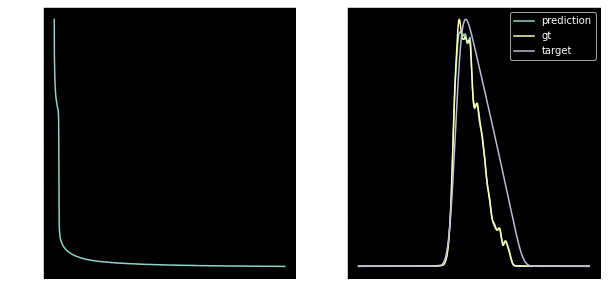

In [569]:
fig,ax = plt.subplots(1,2, figsize=(10,5))
ax[0].plot(surrogate_loss_evol)
ax[1].plot(x_vals_spectrum,predicted_next_state[0].cpu().detach().numpy(), label='prediction')
ax[1].plot(x_vals_spectrum,next_state[0].cpu().detach().numpy(), label='gt')
ax[1].plot(x_vals_spectrum,target[0].cpu().detach().numpy(), label='target')
ax[1].legend()
plt.show()

In [570]:
agent_rollout = 10

In [577]:
for i in tqdm(range(agent_rollout)):
    # Actor step
    agent.optim.zero_grad()
    agent_init_state = state.clone()
    agent_target = target.clone()
    # Smooth agent state
    if smooth_states:
        agent_init_state = torch.nn.AvgPool1d(kernel_size=kernel_size, stride=1, padding=kernel_size//2)(agent_init_state)    
    # Norm inital state and target
    if norm_states:
        agent_init_state = norm_tensor(agent_init_state, dim=1)
        agent_target = norm_tensor(agent_target, dim=1)

    agent_state = torch.cat([agent_init_state, agent_target],dim=1)

    if mix_batch:
        # Add all states to batch
        agent_state = torch.cat([agent_state, states.float().to(device)])
        #agent_target = torch.cat([agent_target, actions.float().to(device)])

    if exp_batch:
        # Add exp to batch
        exp_states, exp_actions, exp_next_states, exp_org_targets = experiences.sample_all()
        exp_agent_state = torch.cat([exp_states, exp_org_targets],dim=1)
        agent_state = torch.cat([agent_state, exp_agent_state])
        #agent_target = torch.cat([agent_target, exp_org_targets])

    # Infer agent        
    predicted_action = agent.agent(agent_state)

    # Replace power
    if fixed_power:
        predicted_action[0,0] = fixed_power_value

    # Smooth generated wave
    # This does currently not work!
    if smooth_action_optim:
        action[0,1:] = torch.nn.AvgPool1d(kernel_size_action, stride=1, padding=kernel_size_action//2)(action[0,1:].unsqueeze(0).unsqueeze(0)).squeeze(0).squeeze(0)

    # Normalize agent output
    if norm_output:
         predicted_action = torch.cat([predicted_action[:,0].unsqueeze(1),norm_tensor(predicted_action[:,1:], dim=-1)],dim=-1)        

    # Use surrogate as differentiable environment simulation        
    #predicted_next_state = surrogate.agent(torch.cat([state,predicted_action],dim=1))
    #predicted_next_state = surrogate.agent(torch.cat([surrogate_state[:,:int(surrogate_state.shape[1]//2)],predicted_action],dim=1))
    predicted_next_state = surrogate.agent(torch.cat([agent_state[:,:int(agent_state.shape[1]//2)],predicted_action],dim=1))


    # Update agent
    #agent_loss = agent.loss_f(predicted_next_state, norm_tensor(target, dim=1))
    agent_loss = agent.loss_f(predicted_next_state, agent_state[:,int(agent_state.shape[1]//2):])
    agent_loss.backward()
    agent.optim.step()

100%|██████████| 10/10 [00:00<00:00, 291.10it/s]


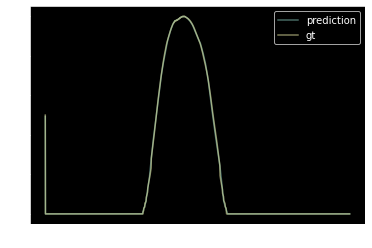

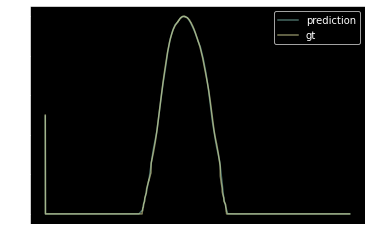

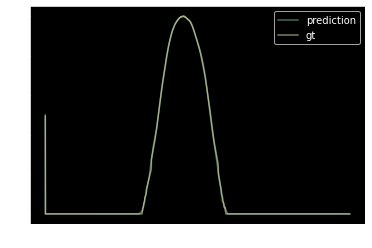

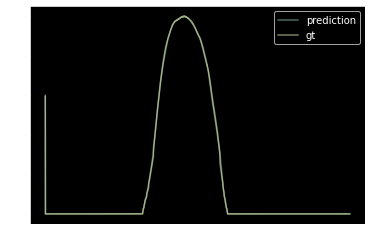

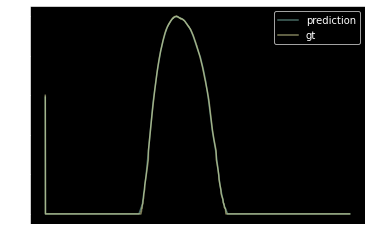

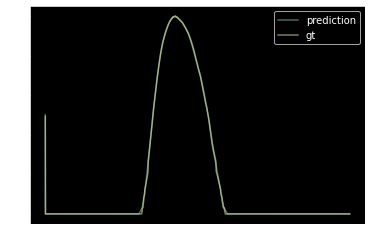

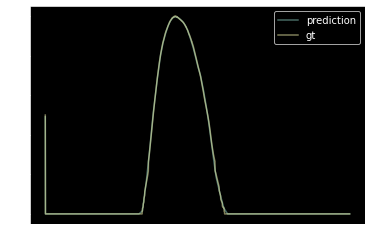

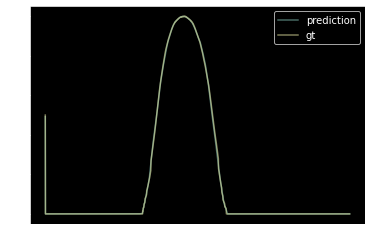

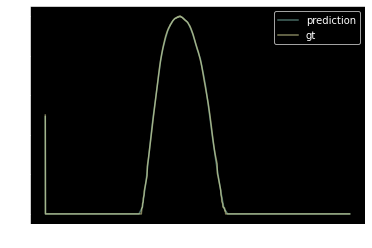

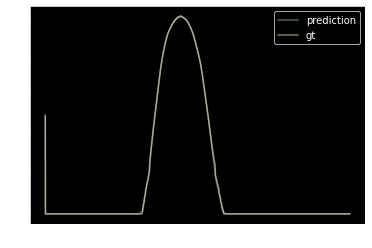

In [93]:
if pwl_train:
    agent.agent.pwl = True
    predicted_action = agent.agent(agent_state)
    agent.agent.pwl = False
for i in range(10):
    plt.plot(predicted_action[i+1].cpu().detach().numpy(), label='prediction', alpha=0.5)
    if pwl_train:
        plt.plot(base_actions[i].cpu().detach().numpy(), label='gt', alpha=0.5)
    else:
        plt.plot(actions[i].cpu().detach().numpy(), label='gt', alpha=0.5)
    plt.legend()
    plt.show()

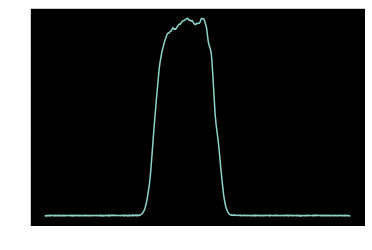

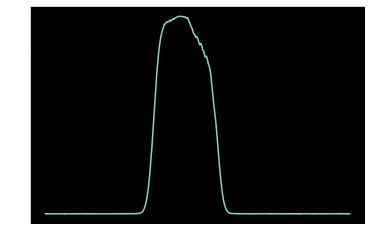

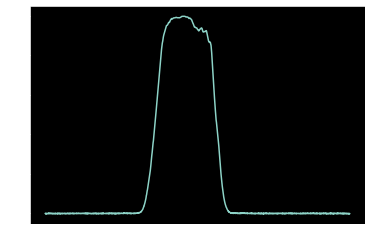

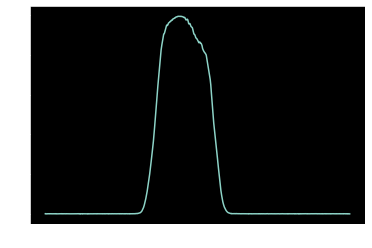

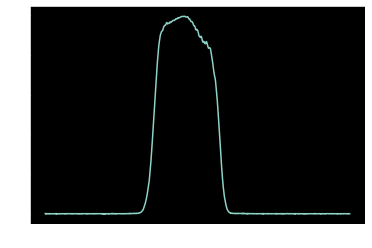

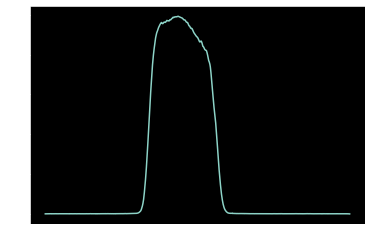

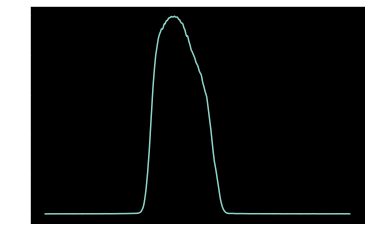

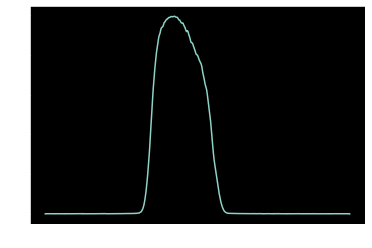

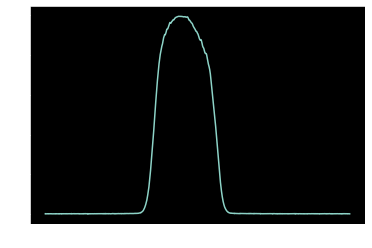

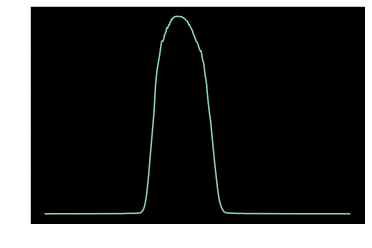

In [102]:
for i in range(10):
    plt.plot(predicted_next_state[i].cpu().detach().numpy())
    plt.show()